In [1]:
## importing packages
import torch
import os
import sys
import joypy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm import tqdm

## exposing path 
sys.path.insert(0, "../")

from int_filt.experiments import create_experiment
from int_filt.utils.config import configuration
from int_filt.utils.utils import ensure_reproducibility, move_batch_to_device

In [2]:
## globals
ACTIVATIONS = {
    "relu": torch.nn.ReLU()
}

OPTIMIZERS = {
    "adam": torch.optim.Adam,
    "adam-w": torch.optim.AdamW
}

SCHEDULERS = {
    "none": None,
    "cosine_annealing": torch.optim.lr_scheduler.CosineAnnealingLR
}

DEVICES = {
    "cpu": torch.device("cpu"),
    "cuda": torch.device("cuda")
}

## defining simulation settings
non_linearity = "exp"
num_dims = 1
num_sims = 1_000
#num_iters = 1_000_000
num_iters = 500_000
sigma_x = 1e-2
sigma_y = 1e-2
beta = 1e-0

## defining plotting settings
num_observations_to_plot = 1_000
num_iters_to_plot = 200

## defining model settings
b_net_amortized = True
b_net_lr = 1e-3
b_net_num_grad_steps = 300
b_net_num_grad_steps = 100

## defining sampling settings
num_samples = 300
num_time_steps = 300

## defining mc estimation settings
num_mc_samples = 500

## defining optimizer and scheduler settings
scheduler = "none"
optimizer = "adam-w"

## defining preprocessing settings
#preprocessing = "none"
preprocessing = "sim"
#preprocessing = "batch"

## defining hiden dimensions
#hidden_widths = [500]
hidden_widths = [500]*5

Exponential non linearity

In [3]:
## defining configurations
experiment_config = {
    "experiment": "nlg",
    "non_linearity": non_linearity,
    "num_dims": num_dims,
    "num_sims": num_sims,
    "num_iters": num_iters,
    "sigma_x": sigma_x,
    "sigma_y": sigma_y,
    "beta": beta,
    "b_net_amortized": b_net_amortized,
    "b_net_lr": b_net_lr,
    "b_net_num_grad_steps": b_net_num_grad_steps,
    "b_net_scheduler": scheduler,
    "b_net_optimizer": optimizer,
    "b_net_hidden_dims": hidden_widths,
    "num_samples": num_mc_samples,
    "preprocessing": preprocessing,
}
## parsing default arguments
args = configuration(args=[])
## retrieving activations
args.b_net_activation = ACTIVATIONS[args.b_net_activation]
## retrieving device
args.device = DEVICES[args.device]
## creating experiment
args = vars(args)

## setting current configurations
for k, v in experiment_config.items():
    args[k] = v

## adding mc configuration
args["mc_config"] = {"num_samples": args["num_samples"]}

## prepare for training drift
b_net_num_grad_step = args["b_net_num_grad_steps"]
b_net_optimizer = args["b_net_optimizer"]
b_net_scheduler = args["b_net_scheduler"]
b_net_lr = args["b_net_lr"]

## dump dir 
dump_dir = args["dump_dir"]
path = Path(dump_dir)
path.mkdir(parents=True, exist_ok=True)

## reproducibility
random_seed = args["random_seed"]
ensure_reproducibility(random_seed)

## displaying current arguments
print(args)

## creating experiment
experiment_nlg_exp = create_experiment(args)

## joyplot
## retrieving data
#latent_states_nlg_exp = torch.squeeze(experiment_nlg_exp.ssm.sim["latent_states"]).numpy().T
#observations_nlg_exp = torch.squeeze(experiment_nlg_exp.ssm.sim["latent_states"]).numpy().T
## constructing data frame
#observation_indices = np.arange(args["num_iters"])
#observation_indices = np.arange(num_iters_to_plot)
#latent_states_nlg_exp = pd.DataFrame(latent_states_nlg_exp[:num_observations_to_plot, :num_iters_to_plot], columns = observation_indices)
## ridge plot
#fig, axes = joypy.joyplot(latent_states_nlg_exp, ylabels=False)
#plt.plot(experiment_nlg_exp.ssm.sim["latent_states"][:, 0, 0])
#plt.plot(experiment_nlg_exp.ssm.sim["observations"][:, 0, 0])

{'interpolant_method': 'pffp_v0', 'num_samples': 500, 'backbone': 'mlp', 'b_net_hidden_dims': [500, 500, 500, 500, 500], 'b_net_activation': ReLU(), 'b_net_activate_final': False, 'b_net_amortized': True, 'experiment': 'nlg', 'sigma_x': 0.01, 'sigma_y': 0.01, 'beta': 1.0, 'num_dims': 1, 'num_sims': 1000, 'num_iters': 500000, 'non_linearity': 'exp', 'step_size': 0.01, 'log_dir': './out/2024-06-15/run_2024-06-15_03-16-32', 'dump_dir': 'exp/2024-06-15/run_2024-06-15_03-16-32', 'b_net_num_grad_steps': 100, 'b_net_optimizer': 'adam-w', 'b_net_scheduler': 'none', 'b_net_lr': 0.001, 'random_seed': 128, 'device': device(type='cuda'), 'preprocessing': 'sim', 'mc_config': {'num_samples': 500}}


100%|██████████| 499999/499999 [00:12<00:00, 39676.99it/s]


In [4]:
batch = experiment_nlg_exp.get_batch()
print("BEFORE STANDARDIZATION\n")
for k, v in batch.items():
    print(k, "-> mean: ", v.mean(), ", std: ", v.std(), "shape: ", v.shape)
batch = experiment_nlg_exp.preprocessing(batch)
print("\nAFTER STANDARDIZATION\n")
for k, v in batch.items():
    print(k, "-> mean: ", v.mean(), ", std: ", v.std(), "shape: ", v.shape)

BEFORE STANDARDIZATION

x0 -> mean:  tensor(9.0485) , std:  tensor(3.5098) shape:  torch.Size([1000, 1])
x1 -> mean:  tensor(9.0478) , std:  tensor(3.5100) shape:  torch.Size([1000, 1])
xc -> mean:  tensor(9.0485) , std:  tensor(3.5098) shape:  torch.Size([1000, 1])
y -> mean:  tensor(9.0481) , std:  tensor(3.5101) shape:  torch.Size([1000, 1])

AFTER STANDARDIZATION

x0 -> mean:  tensor(0.0133) , std:  tensor(0.9998) shape:  torch.Size([1000, 1])
x1 -> mean:  tensor(0.0130) , std:  tensor(1.0000) shape:  torch.Size([1000, 1])
xc -> mean:  tensor(0.0133) , std:  tensor(0.9998) shape:  torch.Size([1000, 1])
y -> mean:  tensor(0.0132) , std:  tensor(1.0001) shape:  torch.Size([1000, 1])


In [5]:
## initializing optimizer and scheduler
b_net_optimizer = OPTIMIZERS[b_net_optimizer](experiment_nlg_exp.b_net.backbone.parameters(), lr = b_net_lr)
b_net_scheduler = SCHEDULERS[b_net_scheduler]
if b_net_scheduler is not None:
    b_net_scheduler = b_net_scheduler(b_net_optimizer, b_net_num_grad_step)

## constructing optimization config dictionary
b_net_optim_config = {
    "num_grad_steps": b_net_num_grad_step,
    "optimizer": b_net_optimizer,
    "scheduler": b_net_scheduler
}

## training b_net 
experiment_nlg_exp.train(b_net_optim_config)
## saving the weights
torch.save(experiment_nlg_exp.b_net.state_dict(), os.path.join(dump_dir, "b_net_exp.pt"))

Grad Step 100/100, MSELoss: 0.8176301717758179, Learning Rate 0.001: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


100%|██████████| 300/300 [00:00<00:00, 16372.06it/s]

gt_dist.shape=torch.Size([300]), torch.Size([300])
gt_dist.mean()=tensor(5.0414), predicted_dist.mean()=tensor(5.0419)
gt_dist.std()=tensor(0.0104), predicted_dist.std()=tensor(0.6147)


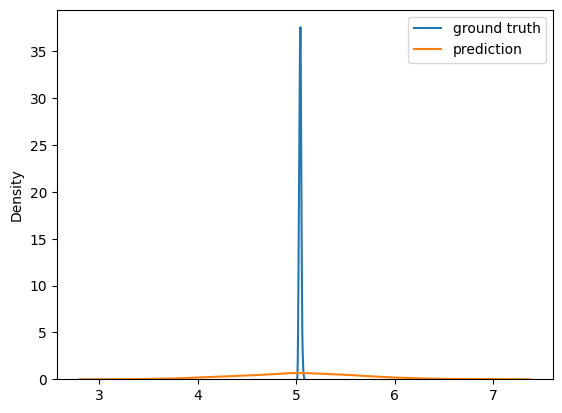

In [6]:
## constructing sampling config dictionary
sample_config = {
    "num_time_steps": num_time_steps,
    "num_samples": num_samples
}

## getting sample batch
batch = experiment_nlg_exp.get_batch()
batch = move_batch_to_device(batch, experiment_nlg_exp.device)

## sampling from model
samples = experiment_nlg_exp.sample(batch, sample_config = sample_config)

## sampling from gt state transition
x = batch["x0"]
samples_gt = torch.zeros_like(samples)
for sample_id in tqdm(range(num_samples)):
    x1 = experiment_nlg_exp.ssm.state_transition(x)
    samples_gt[sample_id] = x1

## plotting example histogram
gt_dist = samples_gt[:, 0, 0]
predicted_dist = samples[:, 0, 0]
print(f"{gt_dist.shape=}, {predicted_dist.shape}")
print(f"{gt_dist.mean()=}, {predicted_dist.mean()=}")
print(f"{gt_dist.std()=}, {predicted_dist.std()=}")
sns.kdeplot(gt_dist, label = "ground truth")
sns.kdeplot(predicted_dist, label = "prediction")
plt.plot(x[0, :])
plt.legend()